## Plotting ALE, PD, and SHAP on the same plot

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import skexplain
import plotting_config
import numpy as np 
import shap
from bayeshist import bayesian_histogram, plot_bayesian_histogram

In [3]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()
X = X.astype({'urban': 'category', 'rural':'category'})

In [4]:
explainer = skexplain.ExplainToolkit(estimators[0],X=X, y=y,)

In [5]:
ale_1d_ds = explainer.ale(features=['temp2m', 'dwpt2m', 'swave_flux', 'sfc_temp'],
                          n_bootstrap=10,
                          subsample=0.1,
                          n_jobs=4, 
                          n_bins=10)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
pd_1d_ds = explainer.pd(features=['temp2m', 'dwpt2m', 'swave_flux', 'sfc_temp'],
                          n_bootstrap=10,
                          subsample=0.1,
                          n_jobs=4, 
                          n_bins=10)


  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
results = explainer.load('shap_values.nc')

In [8]:
import seaborn as sns

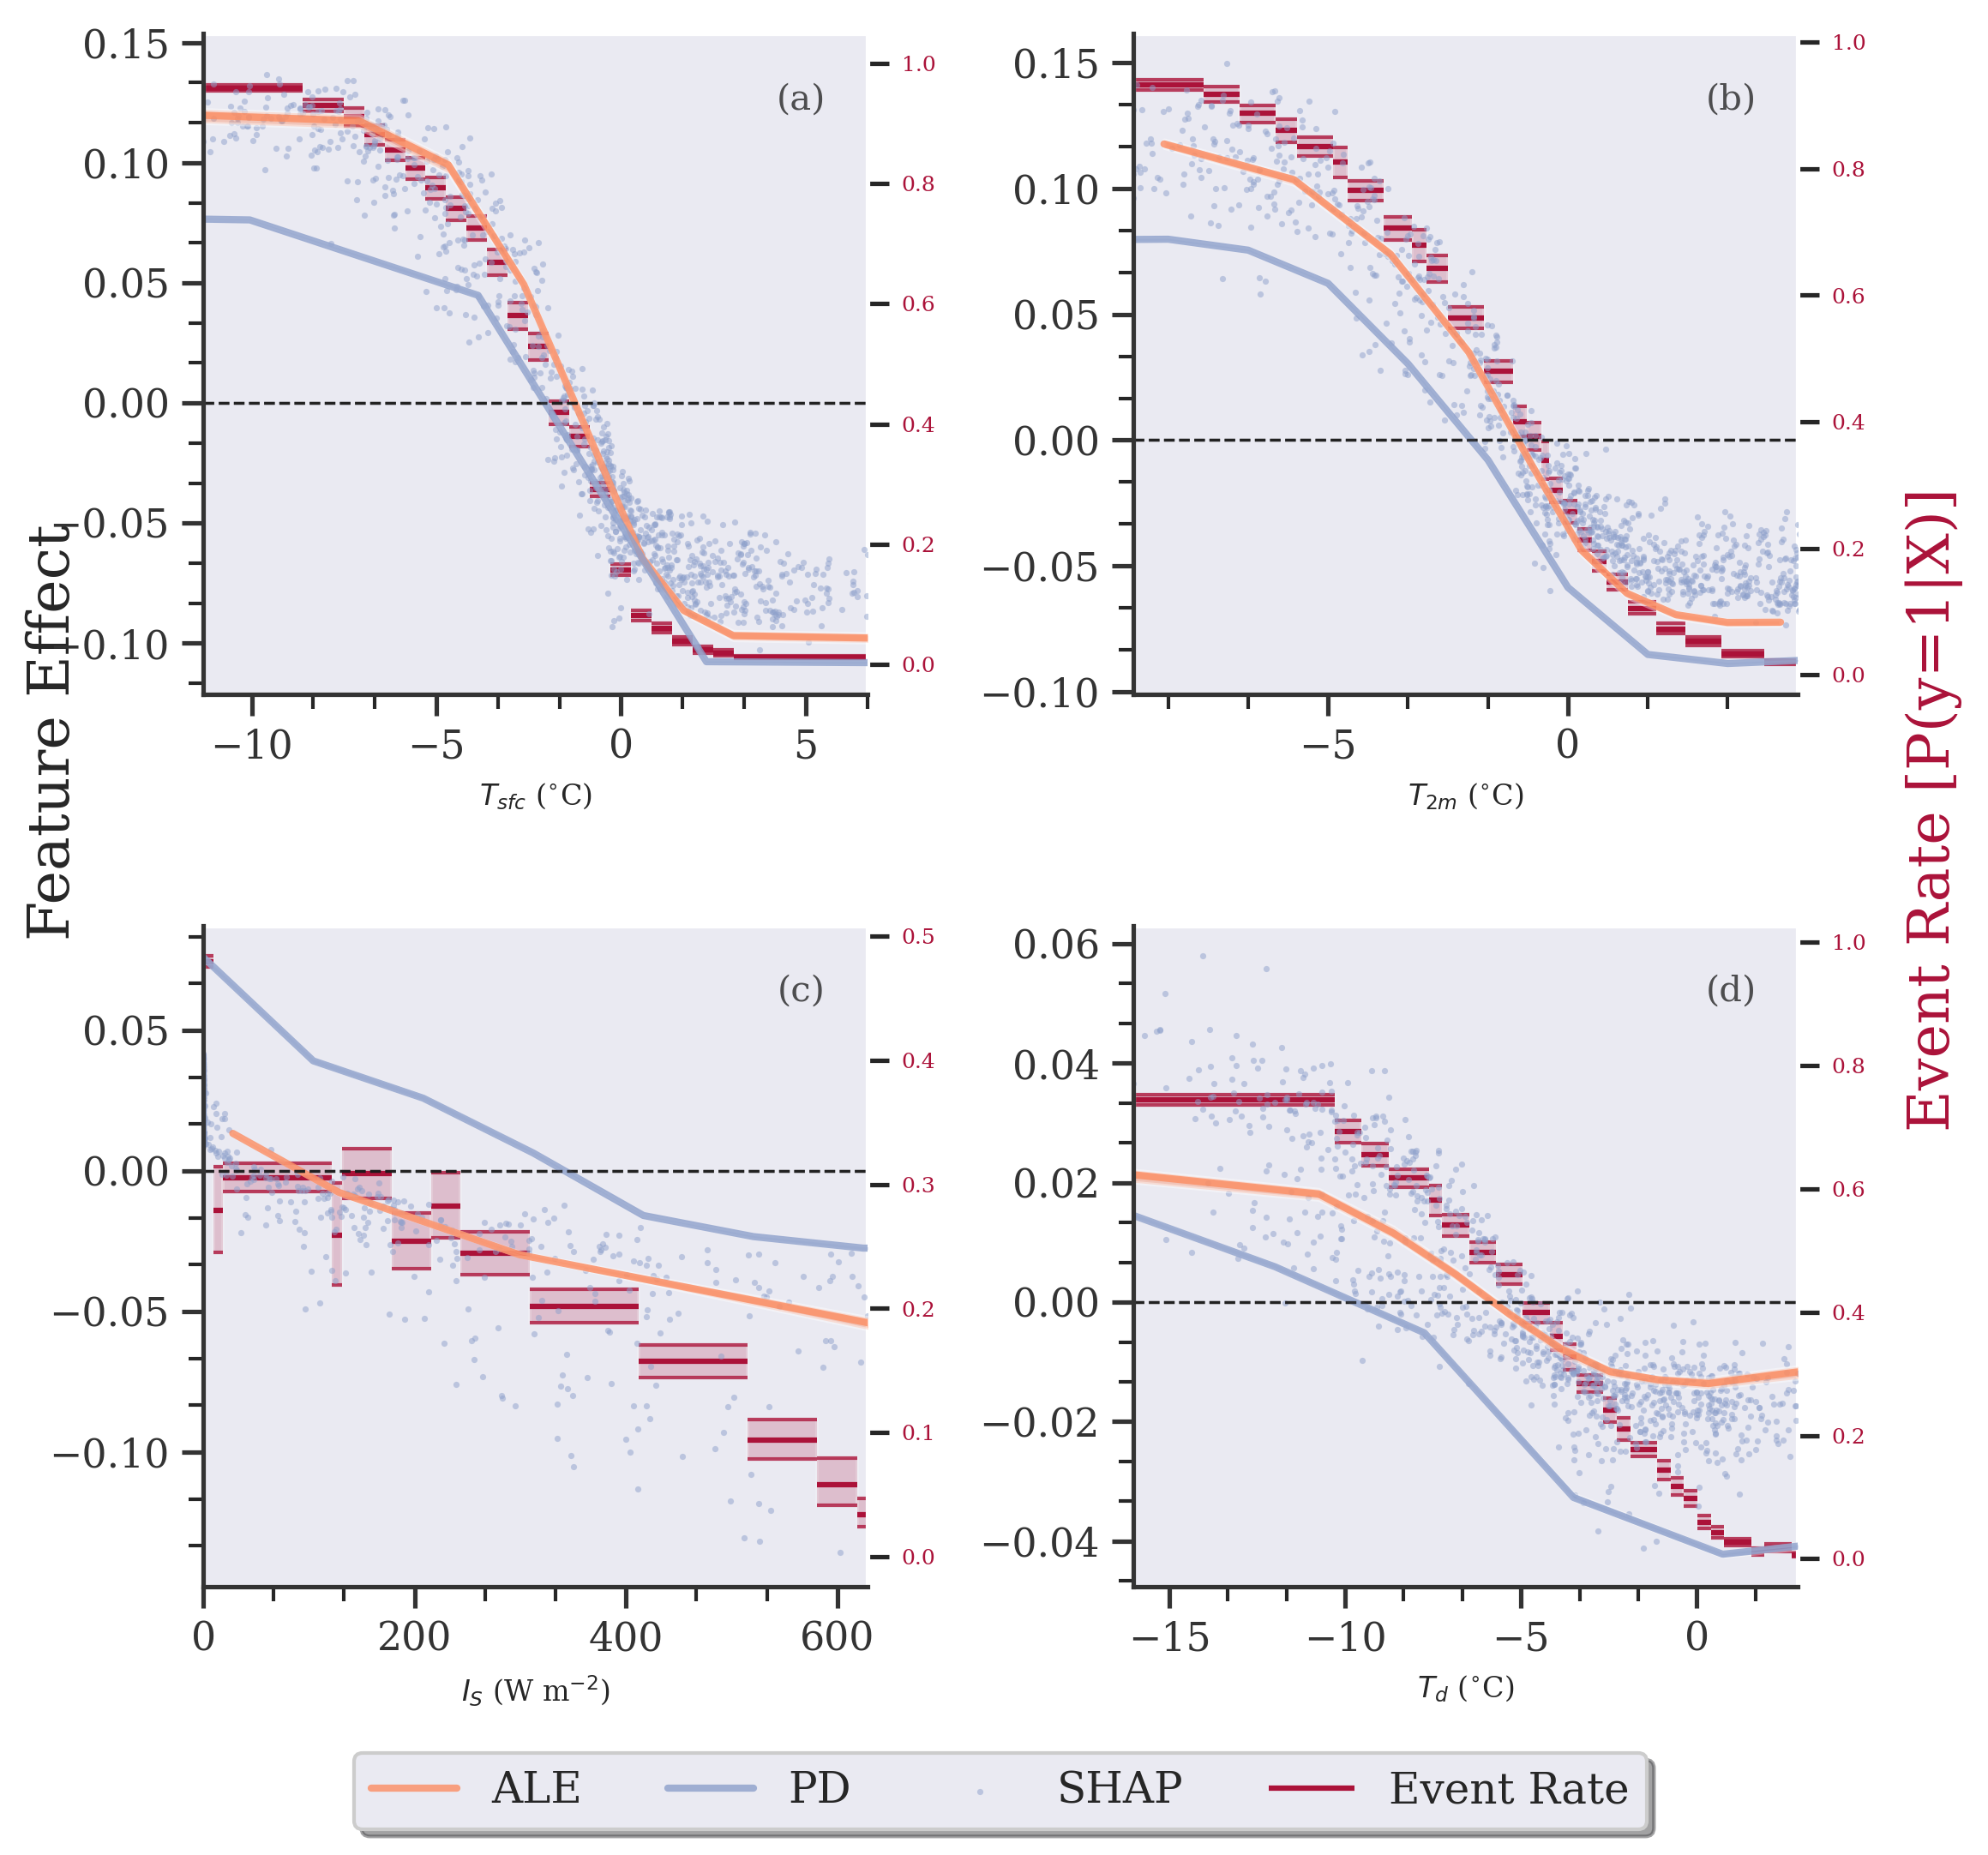

In [9]:
from skexplain.plot.base_plotting import PlotStructure
sns.set_theme()
sns.set_style('darkgrid', {'axes.grid' : False})

features = ['sfc_temp', 'temp2m', 'swave_flux', 'dwpt2m']

n_panels=len(features)
plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, axes = plotter.create_subplots(n_panels=len(features), n_columns=2, figsize=(8,8), dpi=300, 
                                      wspace=0.4, hspace=0.35)

for ax in axes.flat:
    ax.grid()

colors = list(sns.color_palette("Set2"))

for ax, feature in zip(axes.flat, features):
    explainer.plot_ale(ale_1d_ds, 
                   features = [feature],
                   estimator_names = ['Random Forest'],
                   add_hist=False, 
                  display_feature_names=plotting_config.display_feature_names,
                  display_units = plotting_config.display_units,
                  ax=ax, line_kws = {'line_colors' : [colors[1]], 'linewidth': 2.0}, 
                  to_probability=False,
                      )

    # Set add_hist == False since it is already included above.
    explainer.plot_pd(pd_1d_ds, 
                  features = [feature],
                  estimator_names = ['Random Forest'], 
                  ax=ax,
                  add_hist=False, 
                  display_feature_names=plotting_config.display_feature_names,
                  display_units = plotting_config.display_units,
                  line_kws = {'line_colors' : [colors[2]], 'linewidth': 2.0},
                  to_probability=False, 
                 )

    #histdata = X.copy()
    #histdata['target'] = y

    explainer.plot_shap(features=[feature],
                    plot_type = 'dependence',
                    shap_values=results,
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    interaction_index=None,
                    color =colors[2],
                    s = 3, 
                    ax=ax,
                    alpha=0.5,
                    to_probability=False,
    )

    handles, labels = ax.get_legend_handles_labels()
    
    # plot it up
    data = X[feature].values.astype(float)
    bin_edges, beta_dist = bayesian_histogram(data, y,)

    ax_twin = plotter.make_twin_ax(ax)
    plot_bayesian_histogram(bin_edges, beta_dist, ax=ax_twin, color = 'xkcd:rouge', label='Event Rate')

    h, l = ax_twin.get_legend_handles_labels()
    ylabels = ax_twin.get_yticklabels()
    [label.set_color('xkcd:rouge') for label in ylabels]
    
    

major_ax = plotter.set_major_axis_labels(fig, 
                              xlabel=None, 
                              ylabel_left='Feature Effect', 
                              ylabel_right='Event Rate [P(y=1|X)]', title=None,
                              ylabel_right_color = 'xkcd:rouge'
    )    
    
plotter.set_legend(n_panels, fig, ax, major_ax, 
                   handles=handles+h, labels=['ALE', 'PD', 'SHAP', 'Event Rate'],
                   bbox_to_anchor = (0.5, -0.3), ncol=4, fontsize=12,
                  )
plotter.add_alphabet_label(n_panels, axes, pos=(0.9, 0.9))